In [1]:
import os
import sys
import yaml
import torch

sys.path.append('/home/yang_liu/python_workspace/3DGS')
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

import matplotlib.pyplot as plt
from gaussian_renderer import GaussianModel
from arguments import GroupParams
from scene import LargeScene

In [4]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

In [5]:
config = '../config/org_sciart_all.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)

Loading trained model at iteration 30000
Reading camera 2998/2998


central_min: tensor([-179.2104,   11.6078, -245.6177])
central_max: tensor([148.2678,  39.3915,  -4.8320])


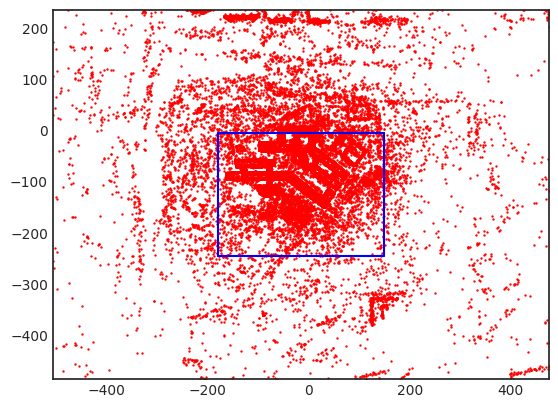

: 

In [10]:
xyz = gaussians.get_xyz
# xyz_median = torch.median(xyz, dim=0)[0]
# delta_median = torch.median(torch.abs(xyz - xyz_median), dim=0)[0]
sorted_x = torch.sort(xyz[::100, 0], descending=True)[0]
sorted_y = torch.sort(xyz[::100, 1], descending=True)[0]
sorted_z = torch.sort(xyz[::100, 2], descending=True)[0]

ratio = 0.999
x_max = torch.quantile(sorted_x, ratio)
x_min = torch.quantile(sorted_x, 1-ratio)
y_max = torch.quantile(sorted_y, ratio)
y_min = torch.quantile(sorted_y, 1-ratio)
z_max = torch.quantile(sorted_z, ratio)
z_min = torch.quantile(sorted_z, 1-ratio)

xyz_min = torch.stack([x_min, y_min, z_min]).detach().cpu()
xyz_max = torch.stack([x_max, y_max, z_max]).detach().cpu()
central_min = xyz_min + (xyz_max - xyz_min) / 3
central_max = xyz_max - (xyz_max - xyz_min) / 3
plt.style.use('seaborn-white')
plt.figure()
plt.scatter(xyz[::100, 0].detach().cpu(), xyz[::100, 2].detach().cpu(), s=0.5, c='r', label='block9')
plt.plot([central_min[0], central_min[0]], [central_min[2], central_max[2]], 'b')
plt.plot([central_max[0], central_max[0]], [central_min[2], central_max[2]], 'b')
plt.plot([central_min[0], central_max[0]], [central_min[2], central_min[2]], 'b')
plt.plot([central_min[0], central_max[0]], [central_max[2], central_max[2]], 'b')
plt.xlim(xyz_min[0], xyz_max[0])
plt.ylim(xyz_min[2], xyz_max[2])
print(f"central_min: {central_min}")
print(f"central_max: {central_max}")